# DES Y1 Likelihood for $w$CDM Model

**Note: BayesFast is still under development. 
Currently, this notebook is based on commit b724bfb.**

Getting the DES chains, which are not shipped with BayesFast.

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
if not os.path.exists('data/des-y1-w-chain-trimmed.txt'):
    import urllib.request
    urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/HerculesJack/bayesfast-example-data/master/des-y1-w-chain-trimmed.txt', 
        'data/des-y1-w-chain-trimmed.txt')

Initializing the [dask](https://distributed.dask.org/en/latest/) client. 
Here we have one node with 64 cores. 
See [this](https://jobqueue.dask.org/en/latest/configurations.html#nersc-cori)
for examples on how to start the client using multiple nodes on NERSC.

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=64, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41755 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 126.70 GB


Loading the DES chains.

In [3]:
import numpy as np

_x_mn = np.loadtxt('data/des-y1-w-chain-trimmed.txt')[:, :27].copy()
_p_mn = np.loadtxt('data/des-y1-w-chain-trimmed.txt')[:, -1].copy()

Initializing the cosmosis pipeline.
We only use cosmosis to compute the models (2pt functions),
which are approximated by polynomial surrogates during sampling.
The remaining computation is implemented in the cells below,
which will be integrated into [CosmoFast](https://github.com/HerculesJack/cosmofast) later.

In [4]:
para_range = np.array([[0.1, 0.9], [0.55, 0.9], [0.03, 0.07], 
                       [0.87, 1.07], [0.5e-9, 5.0e-9], [0.0006, 0.01], 
                       [-2, -0.333], [0.8, 3.0], [0.8, 3.0], 
                       [0.8, 3.0], [0.8, 3.0], [0.8, 3.0], 
                       [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], 
                       [-0.1, 0.1], [-5.0, 5.0], [-5.0, 5.0], 
                       [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], 
                       [-0.1, 0.1], [-0.05, 0.05], [-0.05, 0.05], 
                       [-0.05, 0.05], [-0.05, 0.05], [-0.05, 0.05]])
init_mu = np.array([2.950000e-01,  6.881000e-01,  4.680000e-02,  
                    9.676000e-01, 2.260574e-09,  6.155000e-04, 
                    -1.000000e+00,  1.450000e+00, 1.550000e+00,  
                    1.650000e+00,  1.800000e+00,  2.000000e+00, 
                    1.200000e-02,  1.200000e-02,  1.200000e-02,  
                    1.200000e-02, 0.000000e+00,  0.000000e+00,  
                    2.000000e-03, -1.500000e-02, 7.000000e-03, 
                    -1.800000e-02,  2.000000e-03,  1.000000e-03, 
                    3.000000e-03,  0.000000e+00,  0.000000e+00])
init_sig = (para_range[:, 1] - para_range[:, 0]) / 1000
_nonlinear_indices = np.array([0, 1, 2, 3, 4, 5, 6, 16, 17])
_constrained_indices = np.array([0, 4, 6, 16, 17])

In [5]:
from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline
import sys

old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
ini = Inifile("data/params.ini")
pipeline = LikelihoodPipeline(ini)
sys.stdout = old_stdout

In [6]:
%%time
start = pipeline.start_vector()
results = pipeline.run_results(start)

/global/u2/h/hejia/cosmosis/cosmosis-standard-library/intrinsic_alignments/la_model/linear_alignments.py:104: RuntimeWarning: invalid value encountered in true_divide
  r_I = P_GI / P_II * b_I


CPU times: user 10 s, sys: 345 ms, total: 10.4 s
Wall time: 8.49 s


In [7]:
from scipy.stats import norm
from scipy.linalg import sqrtm

_prior_indices = np.array([18, 19, 20, 21, 12, 13, 14, 15, 22, 23, 24, 25, 26])
_prior_mu = np.array([-0.001, -0.019, 0.009, -0.018, 0.012, 0.012, 0.012, 0.012,
                      0.008, -0.005, 0.006, 0.0, 0.0])
_prior_sig = np.array([0.016, 0.013, 0.011, 0.022, 0.023, 0.023, 0.023, 0.023, 
                       0.007, 0.007, 0.006, 0.01, 0.01])
_prior_norm = (
    -0.5 * np.sum(np.log(2 * np.pi * _prior_sig**2)) - np.sum(np.log(
    norm.cdf(para_range[_prior_indices, 1], _prior_mu, _prior_sig) -
    norm.cdf(para_range[_prior_indices, 0], _prior_mu, _prior_sig))) - 
    np.sum(np.log(para_range[:12,1] - para_range[:12,0])) - 
    np.sum(np.log(para_range[16:18,1] - para_range[16:18,0])))

_d = results.block['data_vector', '2pt_data']
_invC = results.block['data_vector', '2pt_inverse_covariance']
_invC_r = sqrtm(_invC)
_d_diag = _d @ _invC_r
_norm = results.block['data_vector', '2pt_norm']

def des_prior_f(x):
    chi2 = -0.5 * np.sum(((x[_prior_indices] - _prior_mu) / _prior_sig)**2)
    return chi2 + _prior_norm

def des_prior_j(x):
    foo = np.zeros((1, 27))
    foo[0, _prior_indices] = -(x[_prior_indices] - _prior_mu) / _prior_sig**2
    return foo

def des_2pt_theory(x):
    try:
        import os, sys
        os.environ['OMP_NUM_THREADS'] = '1'
        from cosmosis.runtime.config import Inifile
        from cosmosis.runtime.pipeline import LikelihoodPipeline

        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        ini = Inifile("data/params.ini")
        pipeline = LikelihoodPipeline(ini)
        sys.stdout = old_stdout
        res = pipeline.run_results(x)
        return res.block['data_vector', '2pt_theory'] @ _invC_r
    except:
        return np.nan * np.ones(457)

def chi2_f(m):
    return np.atleast_1d(-0.5 * np.sum((m - _d_diag)**2) + _norm)

def chi2_fj(m):
    return (np.atleast_1d(-0.5 * np.sum((m - _d_diag)**2) + _norm), 
            -(m - _d_diag)[np.newaxis])

def des_post_f(like, x):
    return like + des_prior_f(x)

def des_post_fj(like, x):
    return like + des_prior_f(x), np.concatenate(
        (np.ones((1, 1)), des_prior_j(x)), axis=-1)

BayesFast is not documented yet. Below is a brief note on its usage.
Not all the functionality is used in this notebook.

* `Module` : analogous to cosmosis modules, with optional analytic Jacobian. 
  * ```
    __init__(self, fun=None, jac=None, fun_and_jac=None,
             input_vars=['__var__'], output_vars=['__var__'],
             copy_vars=None, paste_vars=None, delete_vars=None,
             recombine_input=False, recombine_output=False,
             var_scales=None, label=None, fun_args=(), fun_kwargs={},
             jac_args=(), jac_kwargs={}, fun_and_jac_args=(),
             fun_and_jac_kwargs={})
    ```
  * You may define its `fun` and/or `jac` and/or `fun_and_jac`,
    and call them with `Module.fun` etc.
    When `Module.fun` is called, we will first check if you have defined its `fun`.
    If not, we will check if you have defined its `fun_and_jac`.
    If still not, an exception will be raised. Similar for `Module.jac` and `Module.fun_and_jac`.
  * You need to specify the name(s) of `input_vars` and `output_vars`
    as a list of strings, or a string if there is only one variable.
    This will be used to track the variables during the evaluation of the pipeline.
    All the variables should be stored and used as 1-d numpy arraies.
  * Let's say we have a `Module` with `input_vars` A and B, whose shapes are `(a,)` and `(b,)`.
    While the `output_vars` are C and D, whose shapes are `(c,)` and `(d,)`.
    Then the signature of its `fun` should be `(a,),(b,)->(c,),(d,)`.
    The signature of its `jac` should be `(a,),(b,)->(c,a+b),(d,a+b)`.
    The signature of its `fun_and_jac` should be `(a,),(b,)->((c,),(d,)),((c,a+b),(d,a+b))`.
  * For convenience, you can also use the arguments `recombine_input` and `recombine_output`.
    For the example above, if `recombine_input` is True, 
    the input of `fun` should have shape `(a+b,)`.
    Assuming `a+b=e+f`, if `recombine_input` is `(e,f)`, 
    the input should have shape `(e,f)`. Similar for `recombine_output`.

In [8]:
import bayesfast as bf

m_0 = bf.Module(fun=des_2pt_theory, input_vars='x', 
                output_vars='m')
m_1 = bf.Module(fun=chi2_f, fun_and_jac=chi2_fj,
                input_vars='m', output_vars='like')
m_2 = bf.Module(fun=des_post_f, fun_and_jac=des_post_fj,
                input_vars=['like', 'x'], output_vars='logp')

* `Density`: derived from `Pipeline`, analogous to cosmosis LikelihoodPipeline.
  * ```
    __init__(self, module_list=None, input_vars=['__var__'], var_dims=None,
             surrogate_list=None, var_scales=None, hard_bounds=False)
    ```
  * The overall input of `Density` should be a single array, 
    and you need to tell us how to split it using `input_vars` and `var_dims`.
  * `var_scales` should have shape `(input_size, 2)`. 
    If None, it will be set as `((0,1),(0,1)...)`.
  * If `hard_bounds` is False, 
    we only linearly rescale it by mapping `var_scales` to `((0,1),(0,1)...)`.
    If `hard_bounds` is True,
    we will transform it to `((-inf,+inf),(-inf,+inf)...)` using nonlinear transformation.
    You can also set it separately for each variable 
    by using an array with shape `(input_size, 2)` for `hard_bounds`.

In [9]:
d_0 = bf.Density(density_name='logp', module_list=[m_0, m_1, m_2], 
                 input_vars='x', var_dims=27, var_scales=para_range,
                 hard_bounds=True)
d_0(start), results.post

/global/u2/h/hejia/cosmosis/cosmosis-standard-library/intrinsic_alignments/la_model/linear_alignments.py:104: RuntimeWarning: invalid value encountered in true_divide
  r_I = P_GI / P_II * b_I


(array(5301.51629276), 5301.516292761802)

* `PolyConfig`: used to config `PolyModel`.
  * ```
    __init__(self, order, input_mask=None, output_mask=None, coef=None)
    ```
  * `order` should be one of `('linear', 'quadratic', 'cubic-2', 'cubic-3')`, 
    where `cubic-2` means cubic model without 'xyz' terms.
  * If you only want to define it on some of the input (output) variables,
    you can use `input_mask` (`output_mask`).


* `Surrogate`: derived from `Module`.
  * ```
    __init__(self, input_size=None, output_size=None, scope=(0, 1),
             input_vars=['__var__'], output_vars=['__var__'],
             copy_vars=None, paste_vars=None, delete_vars=None,
             recombine_input=True, *args, **kwargs)
    ```
  * `scope`: `(start,extent)`, e.g. `(0,1)` means it will replace #0 `Module` in `module_list`.


* `PolyModel`: derived from `Surrogate`.
  * ```
    __init__(self, configs, *args, **kwargs)
    ```
  * `configs` should be a `PolyConfig` or a list of them. 
    Or you can also just use its `order` if you don't need to set the masks.
    In this case, for example, `'quadratic'` will be interpreted as `('linear','quadratic')`.

Here, during optimization, we use 27-d linear model.
During sampling, we use 27-d linear plus 9-d quadratic model.

In [10]:
s_0 = bf.modules.PolyModel('linear', 27, 457, input_vars='x',
                           output_vars='m', var_scales=para_range)
pc_0 = bf.modules.PolyConfig('linear')
pc_1 = bf.modules.PolyConfig('quadratic', input_mask=_nonlinear_indices)
s_1 = bf.modules.PolyModel([pc_0, pc_1], 27, 457, input_vars='x',
                           output_vars='m', var_scales=para_range)

`alpha_n=2` means we use twice the minimum number of samples required by fitting the surrogate model.

We iterate the block quadratic model for two steps, and in the end, 
we use truncated importance sampling with n=2000 samples, while the weights w are truncated at < w >n^0.25.

At the beginning, you need to provide a bunch of `x_0` to fit the initial surrogate model.

In [11]:
def _in_bound(xx, bound):
    xxt = np.atleast_2d(xx).T
    return np.product([np.where(xi>bound[i,0], True, False) * 
                       np.where(xi<bound[i,1], True, False) for i, xi in 
                       enumerate(xxt)], axis=0).astype(bool)

opt_0 = bf.recipe.OptimizeStep(s_0, alpha_n=2)
sam_0 = bf.recipe.SampleStep(s_1, alpha_n=2, reuse_steps=1, 
                             fit_options={'use_mu_f': True})
sam_1 = bf.recipe.SampleStep(s_1, alpha_n=2, reuse_steps=1, 
                             fit_options={'use_mu_f': True})
pos_0 = bf.recipe.PostStep(n_is=2000, k_trunc=0.25)

x_0 = bf.utils.random.multivariate_normal(init_mu, np.diag(init_sig**2), 100)
x_0 = x_0[_in_bound(x_0, para_range)]
r_0 = bf.recipe.Recipe(density=d_0, client=client, optimize=opt_0, 
                       sample=[sam_0, sam_1], post=pos_0, x_0=x_0, 
                       random_state=1)

In [12]:
r_0.run()

 OptimizeStep proceeding: iter #0 finished.
 OptimizeStep proceeding: iter #1 finished, while delta_pp = 1.565, delta_pq = -1.317.
 OptimizeStep proceeding: iter #2 finished, while delta_pp = 1.166, delta_pq = 0.006.
 OptimizeStep proceeding: iter #3 finished, while delta_pp = 0.014, delta_pq = 0.003.

 ***** OptimizeStep finished. ***** 

 CHAIN #2 : sampling proceeding [ 600 / 3000 ], last 600 samples used 45.68 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 600 / 3000 ], last 600 samples used 46.72 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 600 / 3000 ], last 600 samples used 50.81 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 600 / 3000 ], last 600 samples used 52.03 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 1200 / 3000 ], last 600 samples used 39.74 seconds.
 CHAIN #1 : sampling proceeding [ 1200 / 3000 ], last 600 samples used 39.84 seconds.
 CHAIN #0 : sampling proceeding [ 1200 / 3000 ], last 600 samples used 41.82 seconds.
 CHAIN #3 : sampling pro

/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:122: RuntimeWarning:  CHAIN #3 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:122: RuntimeWarning:  CHAIN #3 : divide by zero encountered in true_divide
  warnings.warn(msg[1], msg[0])


 CHAIN #3 : sampling proceeding [ 2000 / 2500 ], last 500 samples used 21.26 seconds.
 CHAIN #1 : sampling proceeding [ 2000 / 2500 ], last 500 samples used 26.85 seconds.
 CHAIN #0 : sampling proceeding [ 2000 / 2500 ], last 500 samples used 26.53 seconds.
 CHAIN #2 : sampling proceeding [ 2000 / 2500 ], last 500 samples used 28.18 seconds.
 CHAIN #3 : sampling finished [ 2500 / 2500 ], obtained 2500 samples in 113.72 seconds.
 CHAIN #1 : sampling finished [ 2500 / 2500 ], obtained 2500 samples in 135.58 seconds.
 CHAIN #0 : sampling finished [ 2500 / 2500 ], obtained 2500 samples in 138.79 seconds.
 CHAIN #2 : sampling finished [ 2500 / 2500 ], obtained 2500 samples in 140.41 seconds.

 *** SampleStep proceeding: iter #0 finished. *** 

 CHAIN #0 : sampling proceeding [ 900 / 4500 ], last 900 samples used 34.76 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 4500 ], last 900 samples used 35.82 seconds.
 CHAIN #1 : sampling proceeding [ 900 / 4500 ], last 900 samples used 36.04 secon

/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:122: RuntimeWarning:  CHAIN #2 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:122: RuntimeWarning:  CHAIN #2 : divide by zero encountered in true_divide
  warnings.warn(msg[1], msg[0])


 CHAIN #0 : sampling proceeding [ 1800 / 4500 ], last 900 samples used 30.21 seconds.
 CHAIN #1 : sampling proceeding [ 1800 / 4500 ], last 900 samples used 31.54 seconds.
 CHAIN #3 : sampling proceeding [ 1800 / 4500 ], last 900 samples used 32.60 seconds.
 CHAIN #2 : sampling proceeding [ 1800 / 4500 ], last 900 samples used 33.87 seconds.
 CHAIN #0 : sampling proceeding [ 2700 / 4500 ], last 900 samples used 30.58 seconds.
 CHAIN #1 : sampling proceeding [ 2700 / 4500 ], last 900 samples used 31.14 seconds.
 CHAIN #3 : sampling proceeding [ 2700 / 4500 ], last 900 samples used 32.60 seconds.
 CHAIN #2 : sampling proceeding [ 2700 / 4500 ], last 900 samples used 32.24 seconds.


/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:122: RuntimeWarning:  CHAIN #0 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u2/h/hejia/bayesfast/bayesfast/core/sample.py:122: RuntimeWarning:  CHAIN #0 : divide by zero encountered in true_divide
  warnings.warn(msg[1], msg[0])


 CHAIN #0 : sampling proceeding [ 3600 / 4500 ], last 900 samples used 31.86 seconds.
 CHAIN #1 : sampling proceeding [ 3600 / 4500 ], last 900 samples used 31.66 seconds.
 CHAIN #3 : sampling proceeding [ 3600 / 4500 ], last 900 samples used 33.29 seconds.
 CHAIN #2 : sampling proceeding [ 3600 / 4500 ], last 900 samples used 31.94 seconds.
 CHAIN #0 : sampling finished [ 4500 / 4500 ], obtained 4500 samples in 158.85 seconds.
 CHAIN #1 : sampling finished [ 4500 / 4500 ], obtained 4500 samples in 162.41 seconds.
 CHAIN #2 : sampling finished [ 4500 / 4500 ], obtained 4500 samples in 167.09 seconds.
 CHAIN #3 : sampling finished [ 4500 / 4500 ], obtained 4500 samples in 167.33 seconds.

 *** SampleStep proceeding: iter #1 finished. *** 

 ***** SampleStep finished. ***** 

 ***** PostStep finished. ***** 



In [13]:
r_0.get()._fields

('samples', 'weights', 'logp', 'logq', 'samples_raw', 'weights_raw')

In [14]:
r_0.n_call

2530

Removed no burn in
Removed no burn in
Removed no burn in


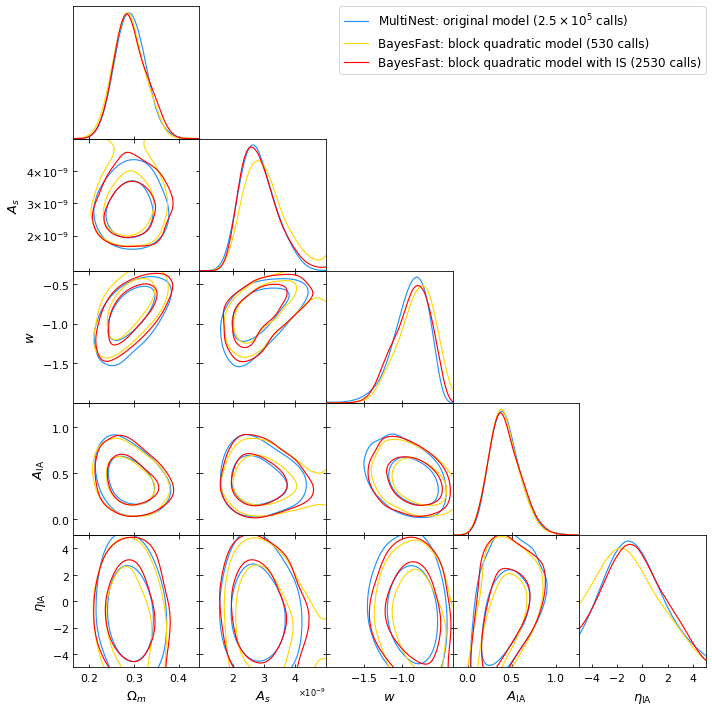

In [16]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(5)]
labels =  ['\\Omega_m', 'A_s', 'w', 'A_{\\rm IA}', '\\eta_{\\rm IA}']
s_bf = MCSamples(
    samples=r_0.get().samples[:, _constrained_indices], names=names, 
    labels=labels, ranges=dict(zip(names, para_range[_constrained_indices])), 
    label='BayesFast: block quadratic model (530 calls)')
s_mn = MCSamples(
    samples=_x_mn[:, _constrained_indices], weights=_p_mn, names=names, 
    labels=labels, ranges=dict(zip(names, para_range[_constrained_indices])), 
    label='MultiNest: original model ($2.5\\times10^5$ calls)')
s_bf_i = MCSamples(
    samples=r_0.get().samples[:, _constrained_indices],
    weights=r_0.get().weights, names=names, 
    labels=labels, ranges=dict(zip(names, para_range[_constrained_indices])), 
    label='BayesFast: block quadratic model with IS (2530 calls)')
g = plots.getSubplotPlotter()
g.settings.figure_legend_loc = 'upper right'
g.settings.axes_fontsize = 14
g.settings.lab_fontsize = 16
g.settings.legend_fontsize = 15
g.settings.lw_contour = 2
g.settings.lw1 = 2
g.triangle_plot([s_mn, s_bf, s_bf_i], filled=False, contour_args={'alpha':1}, 
                diag1d_kwargs={'normalized':True}, contour_colors=['dodgerblue', 
                'gold', 'red'])
plt.show()